# Importation des modules

In [445]:
# modules pour manipuler et visualiser les données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modules pour séparer et évaluer les données
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve, GridSearchCV, RandomizedSearchCV

# modules pour préparer les données
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# modules pour créer et entraîner un modèle
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.dummy import DummyRegressor

# modules pour créer un pipeline 
from sklearn import pipeline
from sklearn.pipeline import make_pipeline

# pour utiliser des modules de maths et des métriques
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt


On prépare notre dataset nettoyé :

In [415]:
dataset = pd.read_csv("dataset.csv")

# On supprime le doublon
dataset = dataset.drop_duplicates()

# Affichage
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# 1. Dummy modèle

## 1.1. Préparation des données

Dans notre étude, on considèrera la variable "bmi" comme une variable catégorielle :

In [416]:
def convert_bmi_to_cat(bmi):
    if bmi < 18.5:
        return "underweight"
    elif bmi < 25:
        return "healthy"
    elif bmi <30:
        return "overweight"
    elif bmi < 40:
        return "obesity"
    else:
        return "morbid_obesity"

In [417]:
dataset['bmi'] = dataset['bmi'].astype(float).apply(lambda x : convert_bmi_to_cat(x))

In [418]:
# La target "charges"
Y = dataset["charges"]

# Les features
X = dataset.drop("charges",axis=1)

# Affichage
X

,age,sex,bmi,children,smoker,region
0,19,female,overweight,0,yes,southwest
1,18,male,obesity,1,no,southeast
2,28,male,obesity,3,no,southeast
3,33,male,healthy,0,no,northwest
4,32,male,overweight,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,obesity,3,no,northwest
1334,18,female,obesity,0,no,northeast
1335,18,female,obesity,0,no,southeast
1336,21,female,overweight,0,no,southwest


On sépare les variables numériques et catégorielle :

In [419]:
var_num = ['age', 'children']

var_cat = ['sex' , 'smoker', 'region', 'bmi']

On applique ensuite deux transformations:<br>
- "sclal" est une transformation de type RobustScaler qui va être appliquée aux colonnes de variables numériques pour normaliser les données en utilisant une échelle robuste aux outliers.<br>
- Le "one_hot_encoder" est une transformation qui va être appliquée aux colonnes de variables catégorielles pour les transformer en variables numériques.

In [420]:
var_num = ['age', 'children']

var_cat = ['sex' , 'smoker', 'region', 'bmi']
col_transform = ColumnTransformer([
    ("sclal", RobustScaler(), var_num),
    
    ("one_hot_encoder",OneHotEncoder(handle_unknown='ignore'), var_cat),
])

Un pipeline est crée pour appliquer les transformations de nos colonnes :

In [421]:
# On crée un pipeline
preprocessor = Pipeline([
    # on applique un transformateur de colonne 
    ('normalizer', col_transform)
])

On divise enfin notre dataset en train set et test set :

In [422]:
# Séparation du dataset en train set (80%) et test set (20%) (stratify sert à bien répartir les fumeurs)
X_train, X_test, y_train, y_test = train_test_split(X, Y,shuffle=True, random_state=42, train_size=0.8,stratify=X[["smoker"]])

## 1.2. Entraînement du modèle

In [423]:
# On crée un modèle de régression 
dummy = DummyRegressor()

# On entraîne le modèle avec notre train set
dummy.fit(X_train, y_train)

# Coefficient de détermination
dummy.score(X_test, y_test)


-0.0010185684988295307

Un score négatif suggère que le modèle "dummy" a une performance plus que médiocre.<br>
Étant donné que la variable à prédire est continue, c’est un problème de régression. On va ’utiliser les algorithmes suivants : régression linéaire, Lasso, Ridge et ElasticNet.<br>
On va essayer plusieurs modèles différents et retenir celui qui a les meilleures performances.<br>

# 2. Régression linéaire

Un modèle de régression linéaire permet de modéliser la relation linéaire de la variable "charges" avec les variables explicatives en supposant au préalable qu'elles soient liées de manière linéaire.

In [424]:
model_reg = make_pipeline(preprocessor, PolynomialFeatures(degree=1),  LinearRegression())
model_reg.fit(X_train,y_train)

scores = cross_validate(model_reg, X_train, y_train, cv=5, scoring=['r2','neg_root_mean_squared_error'])

# Affichez les résultats pour chaque mesure de performance
print("R2: %0.2f (+/- %0.2f)" % (scores['test_r2'].mean(), scores['test_r2'].std()))
print("RMSE: %0.2f (+/- %0.2f)" % (scores['test_neg_root_mean_squared_error'].mean(), scores['test_neg_root_mean_squared_error'].std()))

R2: 0.73 (+/- 0.03)
RMSE: -6267.01 (+/- 388.08)


Une valeur R2 de 0,73 signifie que le modèle explique 73 % de la variance des données.<br>

Le RMSE est de -6267.01, ce qui signifie qu'il existe une grande différence entre les valeurs prédites et les valeurs réelles.  La valeur +/- est l'écart type qui indique la quantité de variation dans les données. 

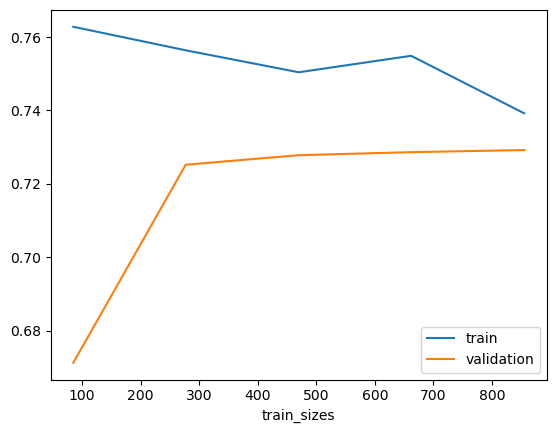

In [437]:
y =learning_curve(model_reg, X_train,y_train,return_times=True)

plt.plot(y[0], y[1].mean(axis=1), label='train')
plt.plot(y[0], y[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

# 2. Lasso

In [425]:
# model= make_pipeline(preprocessor ,PolynomialFeatures(degree=2), Lasso(max_iter=100000,random_state=42))

# parameters = {"lasso__alpha":np.linspace(0.1,100,1000)}

# # On utilise RandomizeSearch pour estimer un intervalle où l'hyperparamètre est probable de se trouver
# randm_src = RandomizedSearchCV(estimator=model, param_distributions=parameters,scoring='r2', cv=5)
# randm_src.fit(X_train, y_train)

# model.set_params(**randm_src.best_params_)
# print(randm_src.best_params_)
# best=randm_src.best_params_

Après plusieurs essais, on trouve que le meilleur hyperparamètre se trouve probablement entre 25 et 45.

In [426]:
# params = {'lasso__alpha':np.linspace(25,45,50)}
# grid=GridSearchCV(estimator= model, param_grid=params, scoring='r2')

# grid.fit(X_train,y_train)
# model.set_params(**grid.best_params_)
# print(grid.best_params_)
# best=grid.best_params_

In [427]:
model= make_pipeline(preprocessor ,PolynomialFeatures(degree=2), Lasso(alpha=35, max_iter=100000,random_state=42))
model.fit(X_train,y_train)

scores = cross_validate(model, X_train, y_train, cv=5, scoring=['r2','neg_root_mean_squared_error'])

# Affichez les résultats pour chaque mesure de performance
print("R2: %0.2f (+/- %0.2f)" % (scores['test_r2'].mean(), scores['test_r2'].std()))
print("RMSE: %0.2f (+/- %0.2f)" % (scores['test_neg_root_mean_squared_error'].mean(), scores['test_neg_root_mean_squared_error'].std()))

R2: 0.85 (+/- 0.03)
RMSE: -4714.53 (+/- 452.46)


Une valeur R2 de 0,71 signifie que le modèle explique 71 % de la variance des données.<br>

Le RMSE est de -6528.15, ce qui signifie qu'il existe une différence entre les valeurs prédites et les valeurs réelles. La valeur +/- est l'écart type qui indique la quantité de variation dans les données. 

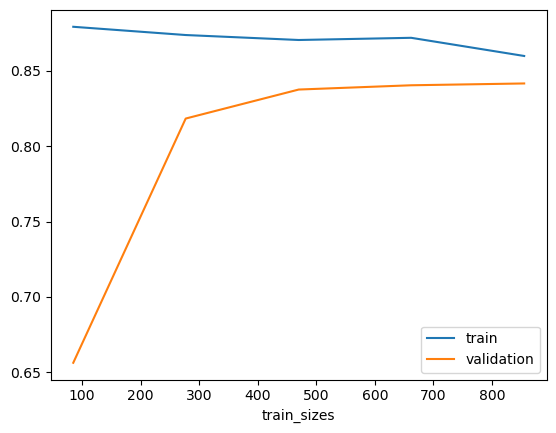

In [438]:
y =learning_curve(model, X_train,y_train,return_times=True)

plt.plot(y[0], y[1].mean(axis=1), label='train')
plt.plot(y[0], y[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

# 3. Ridge

In [428]:
# model= make_pipeline(preprocessor ,PolynomialFeatures(degree=2), Ridge(max_iter=100000,random_state=42))

# parameters = {"ridge__alpha":np.linspace(0.1,100,1000)}
# randm_src = RandomizedSearchCV(estimator=model, param_distributions=parameters,scoring='r2', cv=5)
# randm_src.fit(X_train, y_train)

# model.set_params(**randm_src.best_params_)
# print(randm_src.best_params_)
# best=randm_src.best_params_


In [429]:
# params = {'ridge__alpha':np.linspace(0,20,1000)}
# grid=GridSearchCV(estimator= model, param_grid=params, scoring='r2', cv=5)
# grid.fit(X_train,y_train)

# model.set_params(**grid.best_params_)
# print(grid.best_params_)
# best=grid.best_params_

In [440]:
model_r= make_pipeline(preprocessor ,PolynomialFeatures(degree=2), Ridge(alpha=1.88, max_iter=100000,random_state=42))
model_r.fit(X_train,y_train)

scores = cross_validate(model_r, X_train, y_train, cv=5, scoring=['r2','neg_root_mean_squared_error'])

# Affichez les résultats pour chaque mesure de performance
print("R2: %0.2f (+/- %0.2f)" % (scores['test_r2'].mean(), scores['test_r2'].std()))
print("RMSE: %0.2f (+/- %0.2f)" % (scores['test_neg_root_mean_squared_error'].mean(), scores['test_neg_root_mean_squared_error'].std()))

R2: 0.84 (+/- 0.03)
RMSE: -4770.43 (+/- 440.34)


Une valeur R2 de 0,71 signifie que le modèle explique 71 % de la variance des données.<br>

Le RMSE est de -6528.51, ce qui signifie qu'il existe une différence entre les valeurs prédites et les valeurs réelles. La valeur +/- est l'écart type qui indique la quantité de variation dans les données. 

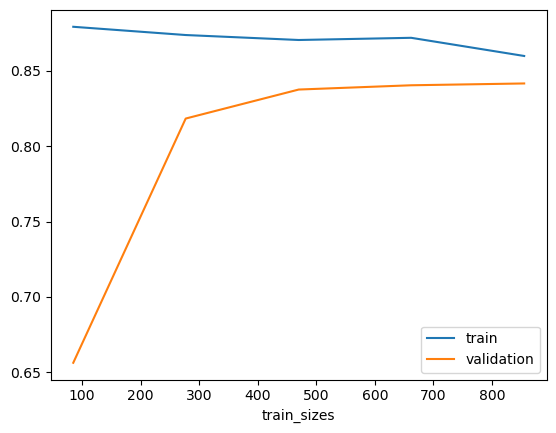

In [441]:
y =learning_curve(model_r, X_train,y_train,return_times=True)

plt.plot(y[0], y[1].mean(axis=1), label='train')
plt.plot(y[0], y[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

# 4. ElasticNet

In [431]:
# param_grid = {'elasticnet__alpha':np.linspace(30,35,100),
#               'elasticnet__l1_ratio':np.linspace(0.01,1,50)}
              
# rdm_grid = RandomizedSearchCV(model, param_grid, cv = 5, scoring = 'r2')
# rdm_grid.fit(X_train, y_train)
# model.set_params(**rdm_grid.best_params_)

# print("Meilleurs hyperparametres : ", rdm_grid.best_params_)
# print("Meilleur score : ", rdm_grid.best_score_)


In [432]:
# grid=GridSearchCV(estimator= model, param_grid=param_grid, scoring='r2', cv=5)
# grid.fit(X_train,y_train)

# model.set_params(**grid.best_params_)
# print(grid.best_params_)
# best=grid.best_params_

In [433]:
model_en= make_pipeline(preprocessor, PolynomialFeatures(degree=2), ElasticNet(alpha=31.51, l1_ratio=1.0, max_iter= 100, random_state=42))

model_en.fit(X_train, y_train)
scores = cross_validate(model_en, X_train, y_train, cv=5, scoring='r2') 

print("R2: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std()))

R2: 0.85 (+/- 0.03)


On compare le modèle de régression linéaire et l'ElasticNet :

In [434]:
print(f"Avec régression linéaire : {model_reg.score(X_test, y_test)}")
print(f"Avec ElasticNet : {model_en.score(X_test, y_test)}")

Avec régression linéaire : 0.8139416352405481
Avec ElasticNet : 0.9188265345333104


/home/apprenant/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.384e+06, tolerance: 1.124e+06
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.540e+07, tolerance: 1.360e+06
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

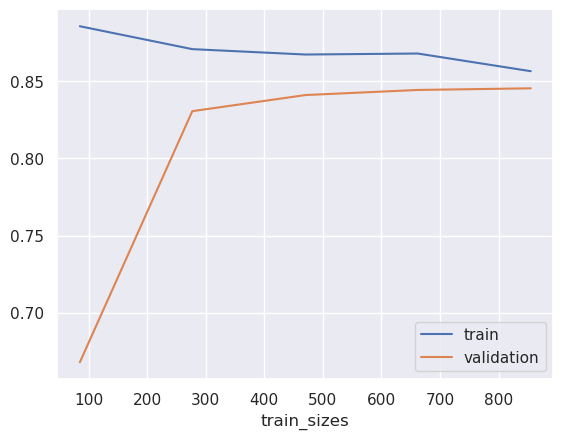

(array([ 85, 277, 470, 662, 855]), array([[0.94331429, 0.87103221, 0.87103221, 0.87103221, 0.87103221],
       [0.88385756, 0.87146138, 0.86602343, 0.86602343, 0.86602343],
       [0.87297785, 0.86376127, 0.86839573, 0.86541927, 0.86541927],
       [0.87982142, 0.87384275, 0.8746414 , 0.85615678, 0.85474547],
       [0.86070254, 0.85532327, 0.85668184, 0.84153946, 0.86776284]]), array([[0.76758957, 0.51132967, 0.69942985, 0.72696076, 0.63518721],
       [0.81862344, 0.832139  , 0.83254097, 0.88245324, 0.78696131],
       [0.82792552, 0.84780322, 0.84131114, 0.89086542, 0.79690779],
       [0.83152999, 0.8468552 , 0.84705914, 0.89563246, 0.80027994],
       [0.83071957, 0.85171243, 0.84711173, 0.89618776, 0.80094537]]), array([[0.01580906, 0.01404977, 0.01084971, 0.01252437, 0.01318908],
       [0.02008748, 0.01356745, 0.01143527, 0.01236224, 0.01449513],
       [0.01370478, 0.01817536, 0.01725531, 0.01376247, 0.01502085],
       [0.01779127, 0.01912546, 0.01528502, 0.01679444, 0.015806

In [456]:
y =learning_curve(model_en, X_train,y_train,return_times=True)

plt.plot(y[0], y[1].mean(axis=1), label='train')
plt.plot(y[0], y[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()
print(y)

### On choisit alors d'utiliser le modèle ELasticNet pour notre étude

# 5. Affinage du modèle choisi (ElasticNet)

## 5.1. Résidus

In [450]:
y_pred = model.predict(X_train)
residual = (y_train - y_pred).abs()

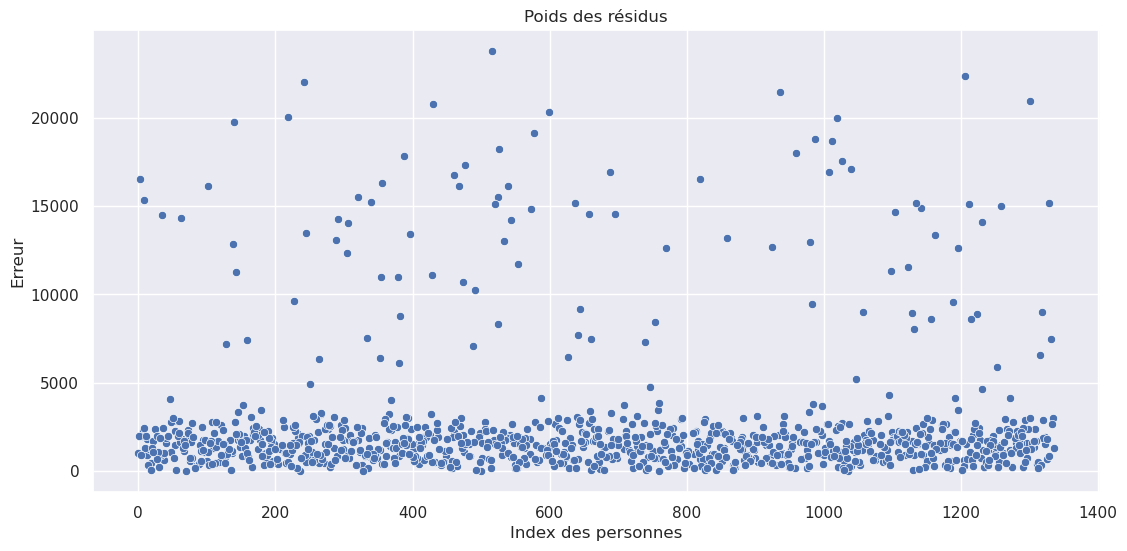

In [455]:
plt.figure(figsize=(13, 6))
sns.scatterplot(x=X_train.index,y=residual)
sns.set(style="darkgrid")

plt.title('Poids des résidus')
plt.ylabel('Erreur')
plt.xlabel('Index des personnes')

plt.show()

## 5.2. Distance de Cook